In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline


# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.model_selection import GridSearchCV
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [ ]:
# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [ ]:
file = ('https://raw.githubusercontent.com/JorgeMendiProject/TFM/main/DatasetInterpolado.csv')
#Lectura de datos a partir del archivo .csv             

dataset = pd.read_csv(file,delimiter=';')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fecha          216 non-null    object 
 1   TasaTPIB       216 non-null    float64
 2   EuriborM       216 non-null    float64
 3   ParoT          216 non-null    float64
 4   SalarioMedio   216 non-null    int64  
 5   IPC            216 non-null    float64
 6   CTotalConsumo  216 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 11.9+ KB


In [ ]:
#Se convierte la variable Fecha a Datetime

dataset['Fecha'] = pd.to_datetime(dataset['Fecha'], format='%d/%m/%Y')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          216 non-null    datetime64[ns]
 1   TasaTPIB       216 non-null    float64       
 2   EuriborM       216 non-null    float64       
 3   ParoT          216 non-null    float64       
 4   SalarioMedio   216 non-null    int64         
 5   IPC            216 non-null    float64       
 6   CTotalConsumo  216 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 11.9 KB


In [ ]:
# Se adecua al formato que tiene el archivo base

dataset = dataset.set_index('Fecha')
dataset = dataset.rename(columns={"Fecha":'x',"TasaTPIB":'y'})  
dataset = dataset.asfreq('M')
dataset = dataset.sort_index()
print(f'Número de filas con missing values: {dataset.isnull().any(axis=1).mean()}', '\n')

# Verificar que un índice temporal está completo
# ==============================================================================
(dataset.index == pd.date_range(
                    start = dataset.index.min(),
                    end   = dataset.index.max(),
                    freq  = dataset.index.freq)
).all()


Número de filas con missing values: 0.0 



True

Fechas train : 2002-01-31 00:00:00 --- 2018-12-31 00:00:00  (n=204)
Fechas test  : 2019-01-31 00:00:00 --- 2019-12-31 00:00:00  (n=12) 



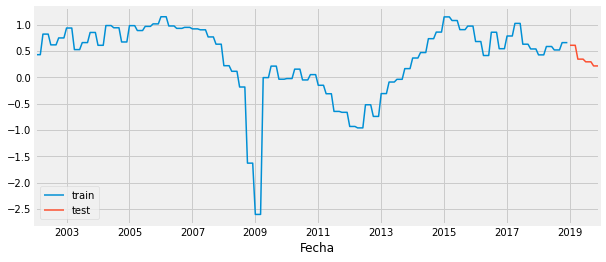

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 12
dataset_train = dataset[:-steps]
dataset_test  = dataset[-steps:]

print(f"Fechas train : {dataset_train.index.min()} --- {dataset_train.index.max()}  (n={len(dataset_train)})")
print(f"Fechas test  : {dataset_test.index.min()} --- {dataset_test.index.max()}  (n={len(dataset_test)})", '\n')

fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
# LINEAR REGRESSOR
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags = 24
                )
forecaster.fit(y=dataset_train['y'])
forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2002-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2023-01-25 16:47:25 
Last fit date: 2023-01-25 16:47:25 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [ ]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones

2019-01-31    0.641547
2019-02-28    0.617553
2019-03-31    0.594049
2019-04-30    0.577045
2019-05-31    0.551459
2019-06-30    0.526462
2019-07-31    0.516606
2019-08-31    0.508901
2019-09-30    0.501414
2019-10-31    0.504232
2019-11-30    0.497955
2019-12-31    0.491864
Freq: M, Name: pred, dtype: float64

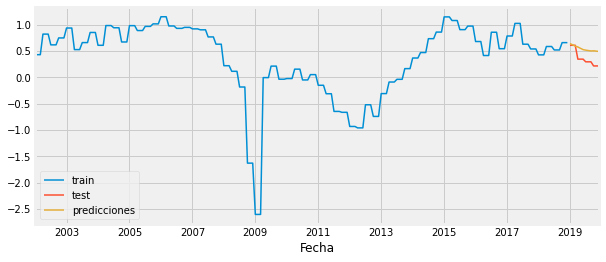

In [ ]:
# Gráfico Predicciones
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test Linear Regressor
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}", '\n')

Error de test (mse): 0.04196337690970598 



In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================

forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = [1, 12, 24]
             )

forecaster.fit(y=dataset_train['y'])


2019-01-31    0.633821
2019-02-28    0.609987
2019-03-31    0.587778
2019-04-30    0.566397
2019-05-31    0.546475
2019-06-30    0.527911
2019-07-31    0.512226
2019-08-31    0.497611
2019-09-30    0.483992
2019-10-31    0.472046
2019-11-30    0.460914
2019-12-31    0.450541
Freq: M, Name: pred, dtype: float64
Error de test (mse) 0.03546472891896116


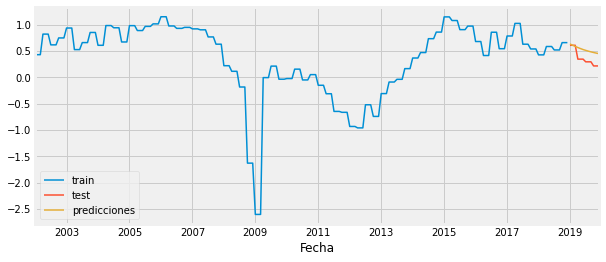

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)
print(predicciones)
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_train['y'].plot(ax=ax, label='train')
dataset_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = dataset_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

In [ ]:
# Backtesting
# ==============================================================================
steps = 3
n_backtesting = steps*4 # Se separan para el backtest los últimos 2 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = dataset['y'],
                                    initial_train_size = len(dataset) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}",'\n')


Information of backtesting process
----------------------------------
Number of observations used for initial training: 204
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   2002-01-31 00:00:00 -- 2018-12-31 00:00:00  (n=204)
    Validation: 2019-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=3)
Data partition in fold: 1
    Training:   2002-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=207)
    Validation: 2019-04-30 00:00:00 -- 2019-06-30 00:00:00  (n=3)
Data partition in fold: 2
    Training:   2002-01-31 00:00:00 -- 2019-06-30 00:00:00  (n=210)
    Validation: 2019-07-31 00:00:00 -- 2019-09-30 00:00:00  (n=3)
Data partition in fold: 3
    Training:   2002-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=213)
    Validation: 2019-10-31 00:00:00 -- 2019-12-31 00:00:00  (n=3)

Error de backtest: 0.014124976185589949 



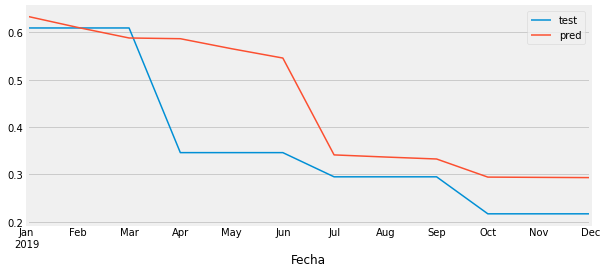

In [ ]:
# Gráfico del Backtesting
# ========================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones_Backtest')
ax.legend();


In [ ]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

,feature,importance
0,lag_1,0.931792
1,lag_12,0.002428
2,lag_24,-0.004489


In [ ]:
variables_exog = ['EuriborM', 'ParoT', 'SalarioMedio', 'IPC','CTotalConsumo']
fin_train = '31/12/2018'
forecaster.fit(
    y= dataset.loc[:fin_train:,'y'],
    exog= dataset.loc[:fin_train:, variables_exog]
    ) # Entrenamiento con conjuntos de train
forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [ 1 12 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['EuriborM', 'ParoT', 'SalarioMedio', 'IPC', 'CTotalConsumo'] 
Training range: [Timestamp('2002-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2023-01-25 16:47:35 
Last fit date: 2023-01-25 16:58:45 
Skforecast version: 0.6.0 
Python version: 3.8.10 

In [ ]:
exog_siguientes_12meses = dataset_test[variables_exog][:12]

predicciones = forecaster.predict(steps=12, exog=exog_siguientes_12meses)
predicciones

2019-01-31    0.629004
2019-02-28    0.669903
2019-03-31    0.714378
2019-04-30    0.781382
2019-05-31    0.804960
2019-06-30    0.816490
2019-07-31    0.825020
2019-08-31    0.861161
2019-09-30    0.895483
2019-10-31    0.972973
2019-11-30    1.001060
2019-12-31    1.010837
Freq: M, Name: pred, dtype: float64

In [ ]:
# Backtesting
# ==============================================================================
steps = 3
n_backtesting = steps*4 #Se separan el útltimo año para el backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = dataset['y'],
                                    exog               = dataset[variables_exog],
                                    initial_train_size = len(dataset) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}",'\n')
predicciones_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 204
Number of observations used for backtesting: 12
    Number of folds: 4
    Number of steps per fold: 3

Data partition in fold: 0
    Training:   2002-01-31 00:00:00 -- 2018-12-31 00:00:00  (n=204)
    Validation: 2019-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=3)
Data partition in fold: 1
    Training:   2002-01-31 00:00:00 -- 2019-03-31 00:00:00  (n=207)
    Validation: 2019-04-30 00:00:00 -- 2019-06-30 00:00:00  (n=3)
Data partition in fold: 2
    Training:   2002-01-31 00:00:00 -- 2019-06-30 00:00:00  (n=210)
    Validation: 2019-07-31 00:00:00 -- 2019-09-30 00:00:00  (n=3)
Data partition in fold: 3
    Training:   2002-01-31 00:00:00 -- 2019-09-30 00:00:00  (n=213)
    Validation: 2019-10-31 00:00:00 -- 2019-12-31 00:00:00  (n=3)

Error de backtest: 0.05478452001100331 



,pred
2019-01-31,0.629004
2019-02-28,0.669903
2019-03-31,0.714378
2019-04-30,0.683527
2019-05-31,0.713633
2019-06-30,0.730773
2019-07-31,0.386223
2019-08-31,0.447782
2019-09-30,0.503899
2019-10-31,0.402371


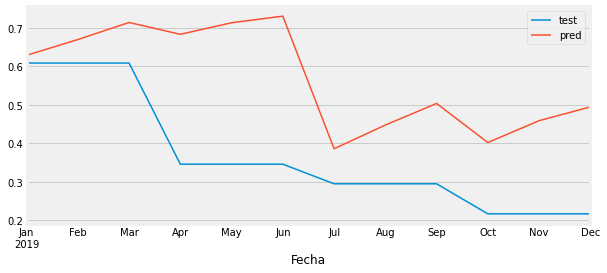

In [ ]:
# Gráfico del Backtesting
# ========================
fig, ax = plt.subplots(figsize=(9, 4))
dataset_test['y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones_backtest')
ax.legend();